# Modelos da Tarefa Competição no Occipital

In [10]:
import pandas as pd
import numpy as np
%matplotlib inline
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

Tratamento da Random Seed

In [2]:
def set_seed(seed: int):
    random.seed(seed) # Python
    np.random.seed(seed)  # Numpy, é o gerador utilizado pelo sklearn
    os.environ["PYTHONHASHSEED"] = str(seed)  # sistema operativo

# Fixar a seed
set_seed(2023)

Load CSVs


In [3]:
df_occ = pd.read_csv('../datasets_manuseados/train_radiomics_occipital_CONTROL_treated.csv')

Float64/Int64 to Float32/Int32

In [4]:
float_features = df_occ.select_dtypes(include='float')
int_features = df_occ.select_dtypes(include='int')
df_occ[float_features.columns] = df_occ[float_features.columns].astype(np.float32)
df_occ[int_features.columns] = df_occ[int_features.columns].astype(np.int32)
df_occ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Columns: 1911 entries, diagnostics_Image-original_Mean to Transition
dtypes: float32(1910), object(1)
memory usage: 2.2+ MB


Train Test Split

In [5]:
X = df_occ.drop(columns=['Transition'])
y = df_occ['Transition']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2023, stratify = y)

### Feature Selection using RFECV and PCA


Fitting estimator with 1910 features.
Fitting estimator with 1910 features.
Fitting estimator with 1910 features.
Fitting estimator with 1909 features.
Fitting estimator with 1909 features.
Fitting estimator with 1909 features.
Fitting estimator with 1908 features.
Fitting estimator with 1908 features.
Fitting estimator with 1908 features.
Fitting estimator with 1907 features.
Fitting estimator with 1907 features.
Fitting estimator with 1907 features.
Fitting estimator with 1906 features.
Fitting estimator with 1906 features.
Fitting estimator with 1906 features.
Fitting estimator with 1905 features.
Fitting estimator with 1905 features.
Fitting estimator with 1905 features.
Fitting estimator with 1904 features.
Fitting estimator with 1904 features.
Fitting estimator with 1904 features.
Fitting estimator with 1903 features.
Fitting estimator with 1903 features.
Fitting estimator with 1903 features.
Fitting estimator with 1902 features.
Fitting estimator with 1902 features.
Fitting esti

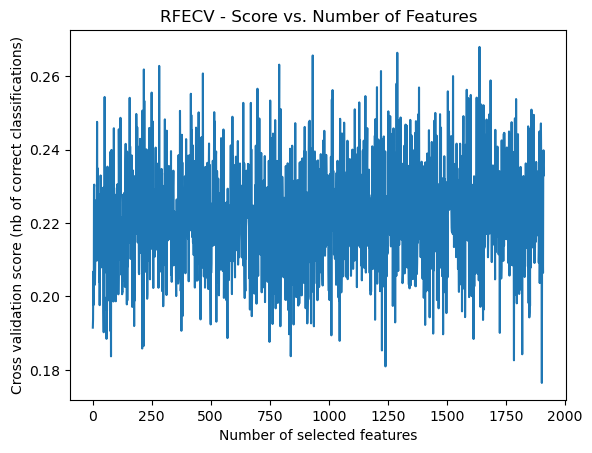

Original number of features (after RFECV): 1638
Number of components selected by PCA: 77


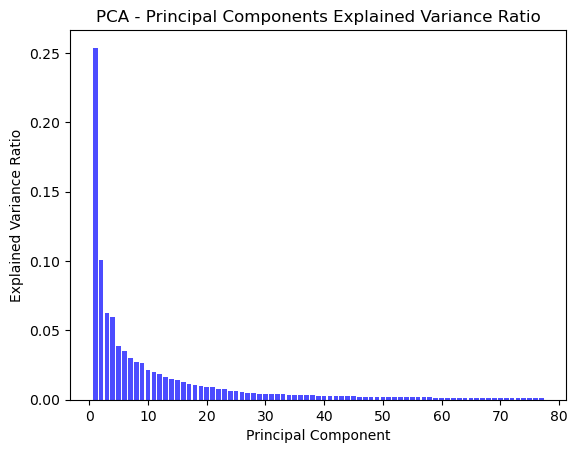

Final shape of the train dataset: (305, 77)
Final shape of the training part of the train dataset: (244, 77)
Final shape of the testing part of the train dataset: (61, 77)


In [6]:
model = RandomForestClassifier(random_state=2023)

### 1. RFECV - Recursive Feature Elimination with Cross-Validation
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(3), scoring='f1_macro', n_jobs=-1, verbose=2)
rfecv.fit(X, y)

rfecv_features = X.columns[rfecv.support_]
print(f"Number of selected features by RFECV: {len(rfecv_features)}")
print(f"Eliminated features by RFECV: {len(X.columns) - len(rfecv_features)}")

plt.figure()
plt.xlabel("Number of selected features")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title("RFECV - Score vs. Number of Features")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

X_rfecv = X[rfecv_features]
X_train_rfecv = X_train[rfecv_features]
X_val_rfecv = X_val[rfecv_features]

### 2. PCA - Principal Component Analysis
pca = PCA(n_components=0.95)
X_final = pca.fit_transform(X_rfecv)
X_train_final = pca.transform(X_train_rfecv)
X_val_final = pca.transform(X_val_rfecv)
print(f"Original number of features (after RFECV): {X_rfecv.shape[1]}")
print(f"Number of components selected by PCA: {pca.n_components_}")

plt.figure()
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, color='blue', alpha=0.7)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA - Principal Components Explained Variance Ratio")
plt.show()

# Final datasets for training and testing
print(f"Final shape of the train dataset: {X_final.shape}")
print(f"Final shape of the training part of the train dataset: {X_train_final.shape}")
print(f"Final shape of the testing part of the train dataset: {X_val_final.shape}")

## Decision Tree Classifier


              precision    recall  f1-score   support

       AD-AD       0.25      0.08      0.12        12
       CN-CN       0.31      0.42      0.36        19
      CN-MCI       0.12      0.50      0.20         2
      MCI-AD       0.11      0.07      0.09        14
     MCI-MCI       0.29      0.29      0.29        14

    accuracy                           0.25        61
   macro avg       0.22      0.27      0.21        61
weighted avg       0.24      0.25      0.23        61



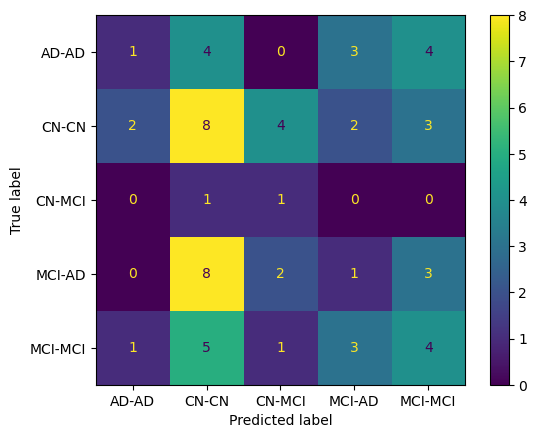

In [8]:
dt = DecisionTreeClassifier(class_weight='balanced', max_leaf_nodes=25, min_samples_leaf=3, random_state=2023, splitter='random')
dt.fit(X_train_final, y_train)
y_pred = dt.predict(X_val_final)
print(classification_report(y_val, y_pred))
ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
plt.show()

## Random Forest Classifier

              precision    recall  f1-score   support

       AD-AD       0.29      0.33      0.31        12
       CN-CN       0.37      0.37      0.37        19
      CN-MCI       0.00      0.00      0.00         2
      MCI-AD       0.20      0.21      0.21        14
     MCI-MCI       0.17      0.14      0.15        14

    accuracy                           0.26        61
   macro avg       0.20      0.21      0.21        61
weighted avg       0.26      0.26      0.26        61



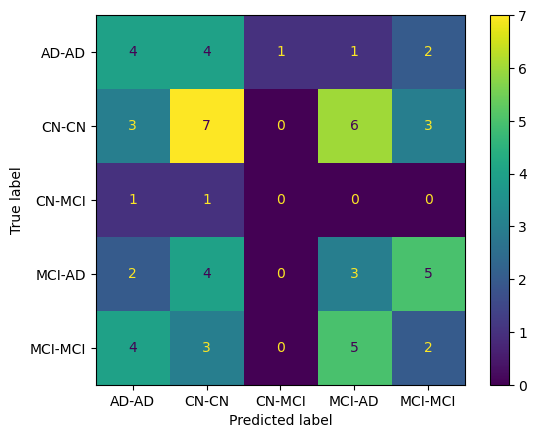

In [12]:
rfc = RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=5, max_features='log2', min_samples_split=10,random_state=2023)
rfc.fit(X_train_final, y_train)
y_pred = rfc.predict(X_val_final)
print(classification_report(y_val, y_pred))
ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
plt.show()

## Support Vector Machine Classifier

              precision    recall  f1-score   support

       AD-AD       0.32      0.50      0.39        12
       CN-CN       0.24      0.21      0.22        19
      CN-MCI       0.00      0.00      0.00         2
      MCI-AD       0.10      0.07      0.08        14
     MCI-MCI       0.17      0.14      0.15        14

    accuracy                           0.21        61
   macro avg       0.16      0.18      0.17        61
weighted avg       0.20      0.21      0.20        61



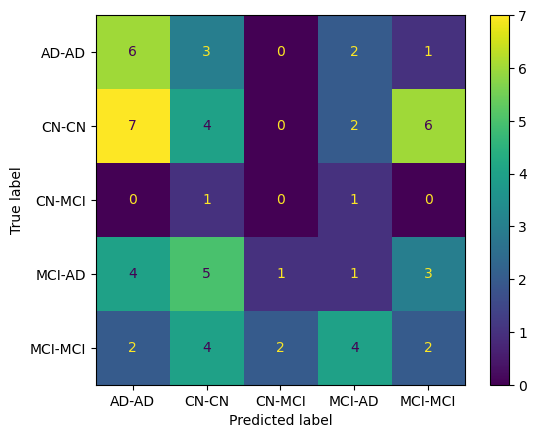

In [11]:
svc = SVC(C=1, class_weight='balanced', decision_function_shape='ovo', degree=2, gamma=0.01, random_state=2023)
svc.fit(X_train_final, y_train)
y_pred = svc.predict(X_val_final)
print(classification_report(y_val, y_pred))
ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
plt.show()

## Gradient Boost Classifier

## XGBoost Classifier

## MLP Classifier

## Stacking Classifier

## Max Voting Classifier